# Setup

Running the simulations presumes the installation of specific packages, in particular Gammapy0.19. The easiest is maybe to simply recreate my conda environment, and run this notebook from there. Download the file env_swyft3-ext.yaml, and write the following in the terminal:

```
$conda env create --file env_swyft3-ext.yaml --name swyft3
$conda activate swyft3
```
Then download the IRF file *Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits* and *ALP_quick_sim.py*. If you place them in the same directory as this notebook, you should be set to run. Otherwise adapt the paths in the following cell:


In [35]:
update_notebook=1

In [36]:
import importlib
loaded_param_function = False

In [37]:
import os

In [38]:
parent_dir = (os.getcwd()+"/").split('/notebooks/', 1)[0]
start_dir = os.getcwd()

In [39]:
ALP_file_dir = parent_dir+"/analysis_scripts/ALP_sim"             # The directory where ALP_quick_sim.py is placed. Can be empty if it's in same folder as notebook. 

In [40]:
import sys
if ALP_file_dir: sys.path.append(ALP_file_dir)   #!!! Change path to location of differential_counts.py and ALP_sim.py
from ALP_quick_sim import ALP_sim
from alp_swyft_simulator import ALP_SWYFT_Simulator

In [41]:
import numpy as np

In [42]:
import matplotlib.pyplot as plt

In [43]:
import swyft

In [44]:
import torch

In [45]:
import scipy.stats as scist

In [46]:
import copy

In [47]:
import ipynbname

In [48]:
import pickle

In [49]:
import subprocess

In [122]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
import wandb

In [51]:
files_name = ipynbname.name() + "_files"
files_dir = os.getcwd() + "/" + files_name 
store_name = ipynbname.name() + "_store"
store_dir = os.getcwd() + "/" + files_name + "/" + store_name

In [52]:
if not os.path.exists(files_dir):
    os.mkdir(files_dir)

In [53]:
rsync_result1 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_simulate.py', files_dir],
                                   capture_output = True, text=True)
rsync_result2 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/ALP_quick_sim.py', files_dir],
                                       capture_output = True, text=True)
rsync_result3 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/alp_swyft_simulator.py', files_dir],
                                       capture_output = True, text=True)
rsync_result4 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/simulate_batch.py', files_dir],
                                       capture_output = True, text=True)
rsync_result5 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_simulate_batch.py', files_dir],
                                       capture_output = True, text=True)
rsync_result6 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_pois.py', files_dir],
                                       capture_output = True, text=True)

In [54]:
A = ALP_sim(set_null=0, set_obs=0)

# Configuration

### Technical

In [55]:
n_sim = 300_000
n_cpus = 128*6
new_store = 0
slurm = 1
conda_env = "swyft4-dev"
slurm_dir = '/home/gert/fox_hpc/ALPs_with_SWYFT/notebooks/' + (os.getcwd()+"/").split('/notebooks/', 1)[1]

max_time_sim = '00-06:00:00'
max_memory_sim = '5'
partition_sim = 'normal'
devel_sim = 0

max_time_train = '00-01:30:00'
max_memory_train = '40'
partition_train = 'accel'
devel_train = 1
gpus = 0



account = 'ec12'
    

### Parameters to be fixed/varied

In [56]:
model_parameter_vals = [
            
    10,                 # mass m in neV
    None,               # coupling constant g in 10^(-11) /GeV
    
    None,               # Amplitude of power law, in "TeV-1 cm-2 s-1"
    None,               # Spectral index of the PWL
    300,                # Reference energy (?) E0, In GeV
    None,               #Cut-off energy Ecut, in GeV
    
    
    None,                # rms of B field, default = 10.
    None,                # normalization of electron density, default = 39.
    None,               # second normalization of electron density, see Churazov et al. 2003, Eq. 4, default = 4.05
    None,               # extension of the cluster, default = 500.
    None,                # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 80.
    None,               # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 200.
    None,                # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 1.2
    None,               # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 0.58
    None,                # scaling of B-field with electron denstiy, default = 0.5
    None,               # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = 0.18
    None,                 # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = 9.
    None               # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = -2.80
            
]

poi_objects = {'model_parameter_vals':model_parameter_vals}
with open(files_dir+'/poi_objects.pickle','wb') as file:
    pickle.dump(poi_objects, file)
os.chdir(files_dir)
config_pois_result = subprocess.run(['python', files_dir+'/config_pois.py'], capture_output = True, text=True)

if loaded_param_function:
    importlib.reload(param_function)
else:
    import param_function
    loaded_param_function = True

os.chdir(start_dir)

A.full_param_vec = param_function.param_function

### Priors and true values

In [114]:
A.configure_model(
    log_params = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    null_params = [-np.inf,1.54e-9,2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80]
)

bounds = [
    [-4,2],
    [1.51e-9, 1.57e-9],
    [2.09,2.13],
    [545,575],
    [8,27],
    [37,48],
    [3.4,4.07],
    [450,550],
    [70,290],
    [276,282],
    [1.0,1.4],
    [0.56,0.60],
    [0.3,0.8],
    [0.16,0.20],
    [8,10],
    [0.8,3.8]
]

truths = np.array([
    [1.4, 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [np.log10(6), 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [np.log10(3), 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [np.log10(1), 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [np.log10(0.2), 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [-1.4, 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [-2.5, 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
    [-3.5, 1.54e-9, 2.11,560,25.,39.,4.05,500.,80.,280.,1.2,0.58,0.5,0.18,9.,-2.80],
])

marginals = [0]

colors = [
    (0,0,1),
    (0,1,.65),
    (0,1,0),
    (1,1,0),
    (1,.6,0),
    (1,0,0),
    (1,0,1),
    (.4,0,1),
]

### Model configuration

In [58]:
A.configure_model(
    model="",
    noise="poisson",
    param_names = param_function.param_names,
    param_units = param_function.param_units,
    ALP_seed=None,
    floor=-1.15,
    floor_obs=-1.15, # not reflected in training set of all_larger_bounds
    logcounts=True,
    residuals=True
)

In [59]:
if update_notebook or not os.path.exists(files_dir+'/config_objects.pickle'):
    A.configure_obs(
        nbins = 150,
        nbins_etrue = 450,
        emin = 6e1,
        emax = 3e3,
        livetime = 10,
        irf_file = parent_dir+"/IRFs/CTA/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"
    )

# Derived Values

In [60]:
simulation_batch_size = int(np.ceil(n_sim/n_cpus))

In [61]:
DEVICE = 'cpu' #if not gpus else 'cuda'

In [115]:
config_objects = {'A':A, 'n_sim':n_sim,'n_cpus':n_cpus, 'bounds':bounds, 'truths':truths, 'simulation_batch_size':simulation_batch_size, 
                  'store_name':store_name,'store_dir':store_dir, 'files_dir':files_dir, 'start_dir':start_dir, 'conda_env':conda_env,
                  'slurm':slurm, 'slurm_dir':slurm_dir, 'gpus':gpus,'max_time_sim':max_time_sim,'max_memory_sim':max_memory_sim,
                  'partition_sim':partition_sim,'devel_sim':devel_sim,'account':account, 'colors':colors, 'marginals':marginals}

In [116]:
with open(files_dir+'/config_objects.pickle','wb') as file:
    pickle.dump(config_objects, file)

# Simulation setup

In [64]:
A.generate_null()

Generating new null-hypothesis... done.


In [65]:
sim = ALP_SWYFT_Simulator(A, bounds)

In [66]:
sim_objects = {'sim':sim}

In [67]:
with open(files_dir+'/sim_objects.pickle','wb') as file:
    pickle.dump(sim_objects, file)

In [68]:
A.nbins

150

# Defining observations

In [69]:
observations = []
for tru in truths:
    sim.A.configure_model(ALP_seed=0)
    obs_exp=sim.generate_exp(tru)
    obs_data = sim.generate_data(obs_exp,tru)
    observations.append(swyft.Sample(data=obs_data, exp=obs_exp, params=tru))
sim.A.configure_model(ALP_seed=None)

In [70]:
with open(files_dir+'/obs_objects.pickle','wb') as file:
    pickle.dump({'observations':observations}, file)

# Loading saved variables

In [71]:
if not update_notebook:
    with open(files_dir+"/"+'config_objects.pickle', 'rb') as file:
        config_objects = pickle.load(file)
    for key in config_objects.keys():
        locals()[key] = config_objects[key]
    
    with open(files_dir+"/"+'sim_objects.pickle', 'rb') as file:
        sim_objects = pickle.load(file)
    for key in sim_objects.keys():
        locals()[key] = sim_objects[key]
    
    with open(files_dir+"/"+'obs_objects.pickle', 'rb') as file:
        obs_objects = pickle.load(file) 
    for key in obs_objects.keys():
        locals()[key] = obs_objects[key]

# Simulating

In [39]:
if not os.path.exists(store_dir):
    os.mkdir(store_dir)
elif new_store:
    rm_result = subprocess.run(['rm','-r', store_dir],
                                       capture_output = True, text=True)
    if slurm:
        rm_slurm_result = subprocess.run(['rm','-r', slurm_dir+"/"+files_name+"/"+store_name],
                                           capture_output = True, text=True)
        
    
store = swyft.ZarrStore(store_dir + "/" + store_name)
store.init(
    N = n_sim,
    chunk_size=simulation_batch_size,
    shapes=sim.get_shapes_and_dtypes()[0],
    dtypes=sim.get_shapes_and_dtypes()[1],
)

In [40]:
if not slurm:
    # !./simulate.sh
    # simulate_result = subprocess.run(['./simulate.sh'], capture_output = True, text=True)
    store.simulate(sim, batch_size=simulation_batch_size)
else:
    if not os.path.exists(slurm_dir + "/" + store_name):
        if not os.path.exists(slurm_dir):
            os.makedirs(slurm_dir)
        os.chdir(files_dir)
        config_simulate_result = subprocess.run(['python', files_dir+'/config_simulate.py'], 
                                                capture_output = True, text=True)
        !chmod +x simulate.sh
        rsync_files_dir_result = subprocess.run(['rsync', '-r', files_dir, slurm_dir],
                                           capture_output = True, text=True)
        os.chdir(start_dir)
        
    print("INSTRUCTIONS:")
    print("Go to " + slurm_dir + files_name + " and run simulate.sh, then continue here")


INSTRUCTIONS:
Go to /home/gert/fox_hpc/ALPs_with_SWYFT/notebooks/stability_checks/all/all_v2_larger_bounds_files and run simulate.sh, then continue here


# Importing and visualizing simulations

### Import from cluster

In [90]:
if slurm:
    rsync_slurm_dir_result = subprocess.run(['rsync', '-r', slurm_dir+"/"+files_name, start_dir],
                                       capture_output = True, text=True)

### Import from local store

In [91]:
store = swyft.ZarrStore(store_dir + "/" + store_name)
samples = store.get_sample_store()

In [92]:
len(samples)

300000

In [93]:
samples['data']

array([[-0.01697138, -0.0153912 , -0.00799039, ...,  0.14902289,
        -0.10478052, -0.0804551 ],
       [-0.00053443,  0.00508008, -0.00239403, ...,  0.07438928,
         0.09933946,  0.03348825],
       [ 0.00279395,  0.00661118, -0.0003715 , ...,  0.10071822,
         0.07131074, -0.1262126 ],
       ...,
       [ 0.00479019, -0.00393157, -0.00570816, ...,  0.07438928,
         0.00916283, -0.00127386],
       [-0.03250204, -0.02223346, -0.0293352 , ..., -0.08833802,
         0.00916283, -0.17736511],
       [-0.01399021, -0.00701644, -0.01898276, ..., -0.05054946,
        -0.02559928, -0.1262126 ]], dtype=float32)

In [94]:
np.where(np.isnan(samples['data']))

(array([], dtype=int64), array([], dtype=int64))

In [95]:
inf_sims = np.where(np.isinf(samples['data']))
print(inf_sims)

(array([], dtype=int64), array([], dtype=int64))


In [96]:
for inf_sim in inf_sims[0]: print(samples['data'][inf_sim])

In [97]:
for i,inf_sim in enumerate(inf_sims[0]):
    samples['data'][inf_sim,inf_sims[1][i]] = samples['data'][inf_sim,inf_sims[1][i]-1]

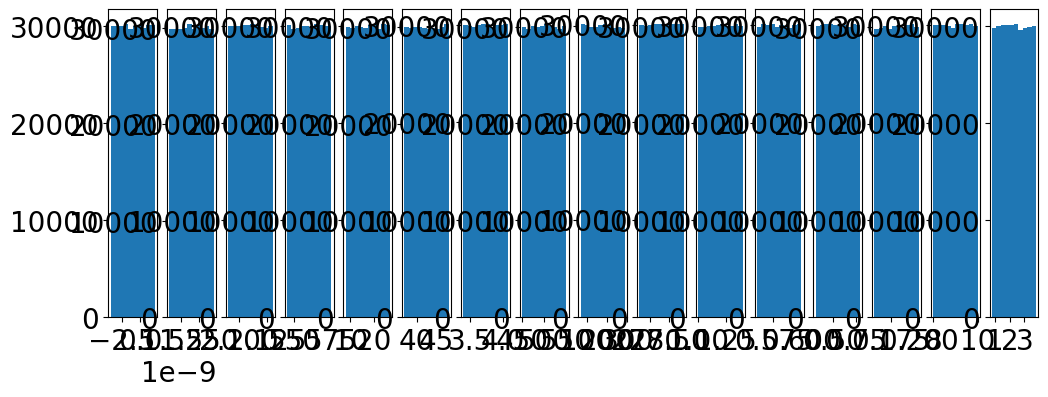

In [98]:
plt.figure(figsize=(12,4))
for i in range(len(bounds)):
    plt.subplot(1,len(bounds),i+1)
    plt.hist(samples['params'][:,i])

Checking that two simulations from the same parameters are identical

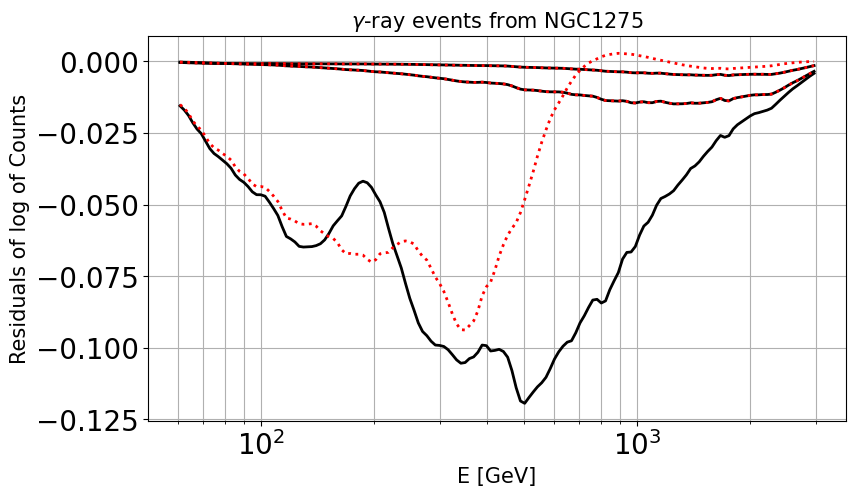

In [99]:
A.configure_plot(xmin=None, xmax=None, legend=0, logx=1, logy=0)
for i in range(min(len(samples),3)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color='k',linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_obs=0)
    A.compute_case(new_fig=0,new_counts=1,color='r',linestyle=":",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_obs=0)


In [100]:
observations[i]['params']

array([ 4.77121255e-01,  1.54000000e-09,  2.11000000e+00,  5.60000000e+02,
        2.50000000e+01,  3.90000000e+01,  4.05000000e+00,  5.00000000e+02,
        8.00000000e+01,  2.80000000e+02,  1.20000000e+00,  5.80000000e-01,
        5.00000000e-01,  1.80000000e-01,  9.00000000e+00, -2.80000000e+00])

Visualizing a selection of simulations in the training set:

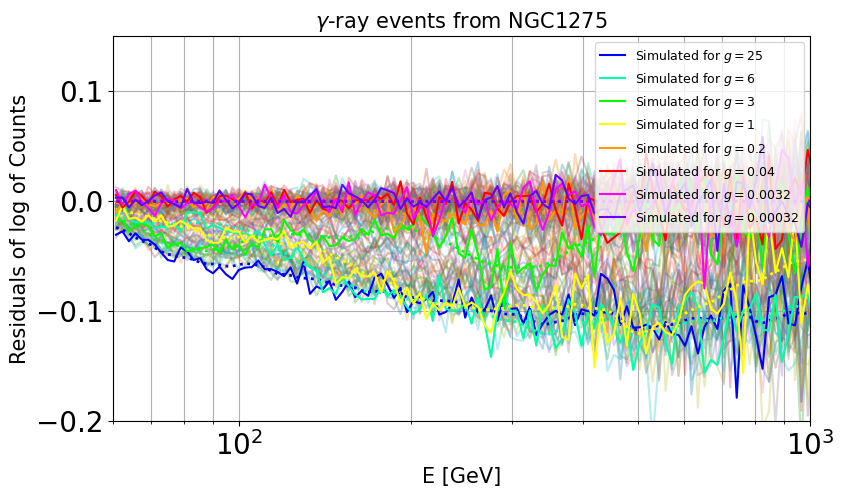

In [117]:
A.configure_plot(xmin=6e1, xmax=1e3, ymin=-0.2,ymax=0.15,legend=0, logx=1, logy=0)
# A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)


A.configure_plot(legend=1)
for i,obs in enumerate(observations):
    A.configure_model(params=obs['params'])
    A.import_counts(obs=obs['data'],exp=obs['exp'])
    shade = i/(len(observations)+1)
    A.compute_case(new_fig=0,new_counts=0,color='k',color_obs=colors[i],linestyle_obs="-",label_exp=1,label_obs=1,
                   errorbands=0, errors=0, plot_exp=0)
    A.compute_case(new_fig=0,new_counts=0,color=colors[i],color_obs=colors[i],linestyle=":",label_exp=0,label_obs=0,
                        errorbands=0, errors=0, plot_obs=0) 

# Training

In [118]:
class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        
        # self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = 5e-5),
        #       torch.optim.lr_scheduler.ReduceLROnPlateau, dict(factor = 0.1, patience=5))
        
        self.norm = swyft.networks.OnlineStandardizingLayer(torch.Size([A.nbins]), epsilon=0)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = A.nbins, 
            num_params = len(marginals), 
            varnames = A.param_names)
        self.learning_rate = 5e-2
    
    def forward(self, A, B):
        data = self.norm(A['data'])
        return self.logratios(data, B['params'][:,marginals])

In [119]:
network = Network()

In [120]:
wandb_logger = WandbLogger(log_model='all')

wandb: Currently logged in as: gertwkl (alps_with_swyft). Use `wandb login --relogin` to force relogin


In [123]:
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64, logger=wandb_logger, # min_epochs =25,
    callbacks = [lr_monitor], log_every_n_steps=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [124]:
dm = swyft.SwyftDataModule(samples, num_workers = 2, batch_size=8192, 
                           on_after_load_sample = sim.get_resampler(targets = ['data']), )

In [125]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                     | Params
-------------------------------------------------------
0 | norm      | OnlineStandardizingLayer | 0     
1 | logratios | LogRatioEstimator_1dim   | 26.9 K
-------------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.216     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/mzm4dxau/checkpoints/epoch=45-step=1380.ckpt


In [126]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-AdamW,████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
lr-AdamW,1e-05
train_loss,-0.54182
trainer/global_step,1529
val_loss,-0.53764


In [127]:
torch.save(network.state_dict(),"trained_network.pt")

# Inference

In [128]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

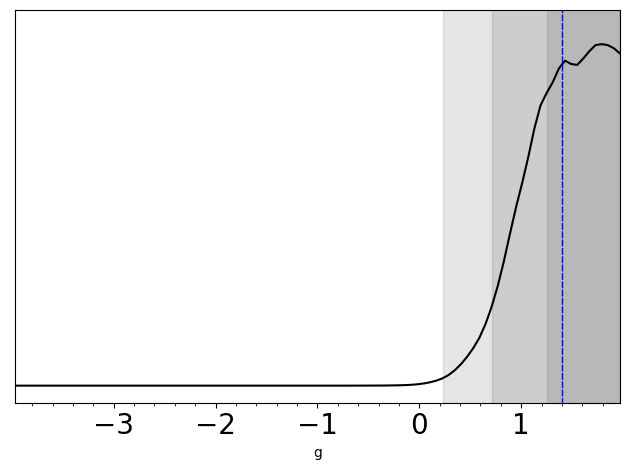

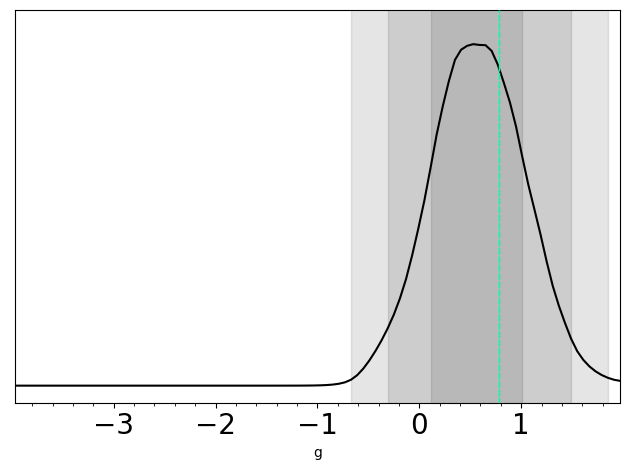

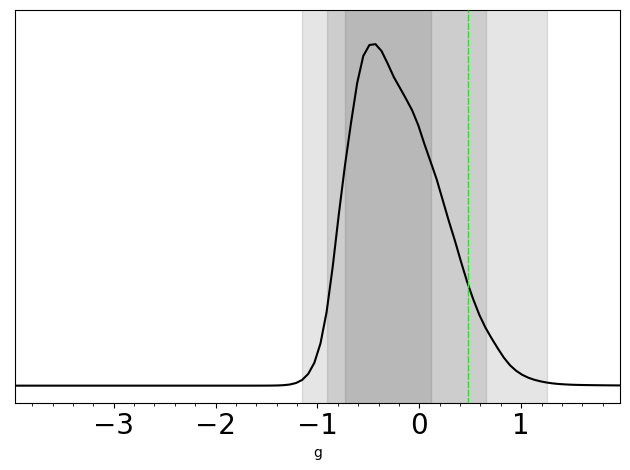

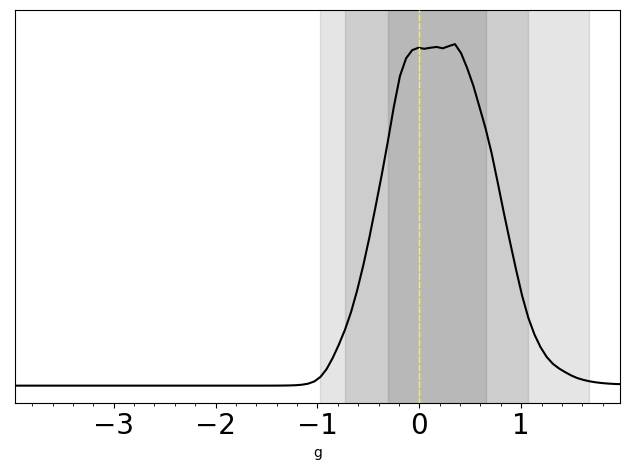

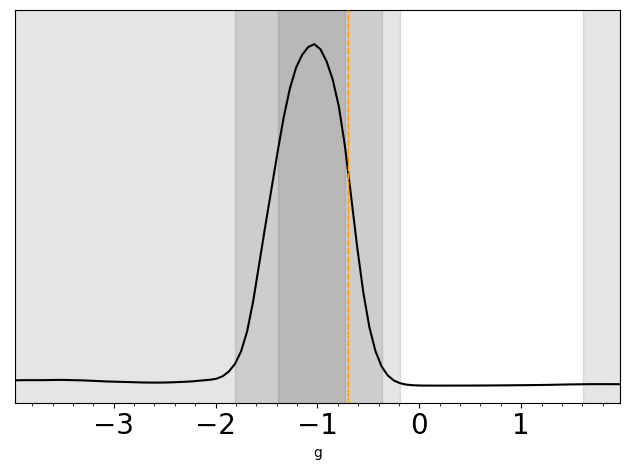

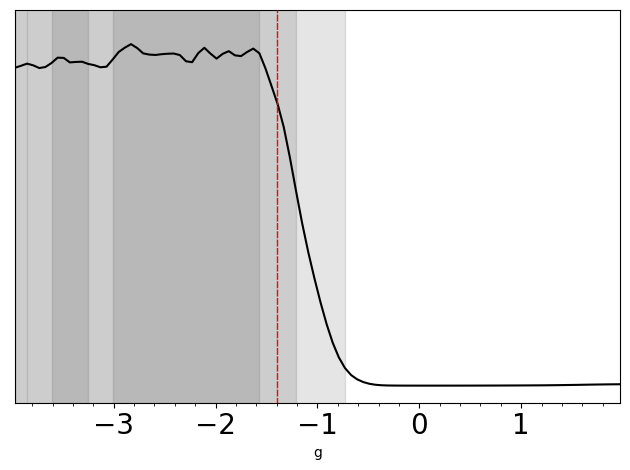

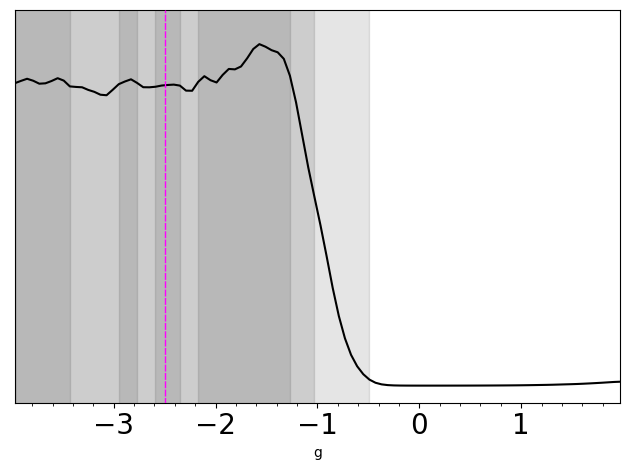

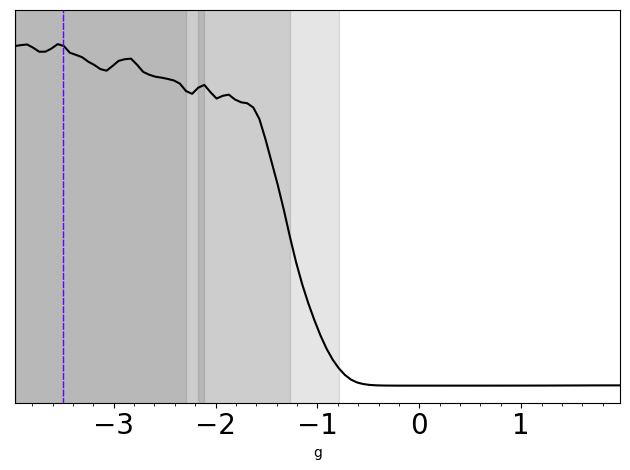

In [129]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            network,
                            observations[j],
                            prior_samples
                            )
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, A.param_names[0], truth={A.param_names[i]:truths[j][i] for i in range(1)}, color_truth=colors[j])

In [130]:
new_net = Network()
new_net.load_state_dict(torch.load('trained_network.pt'))

<All keys matched successfully>

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 30it [00:00, ?it/s]

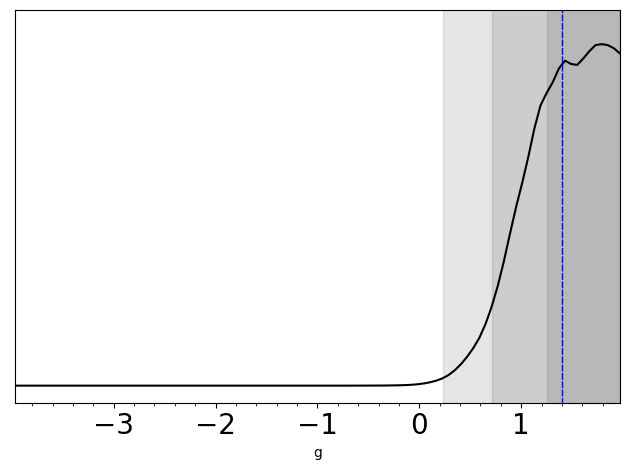

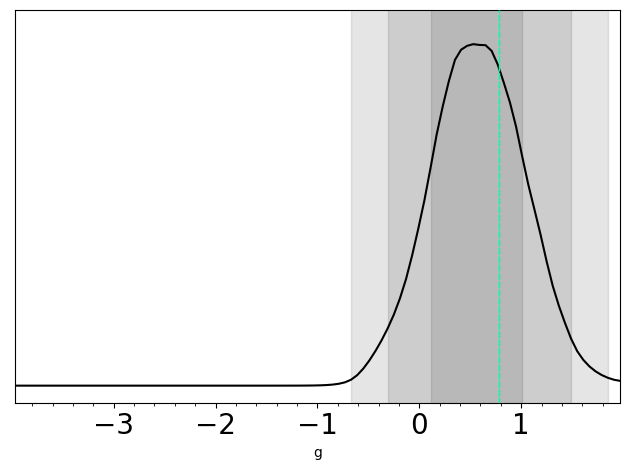

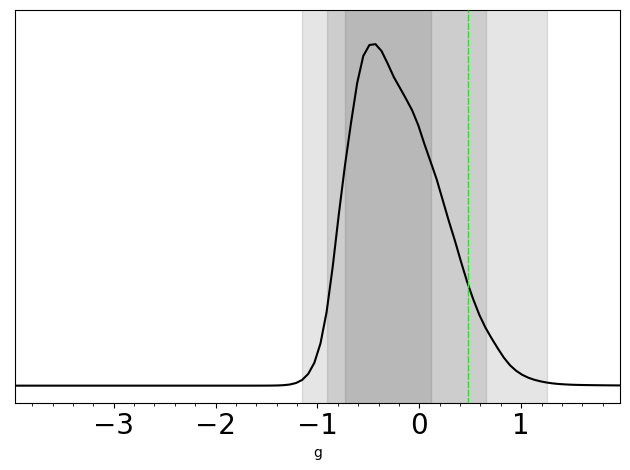

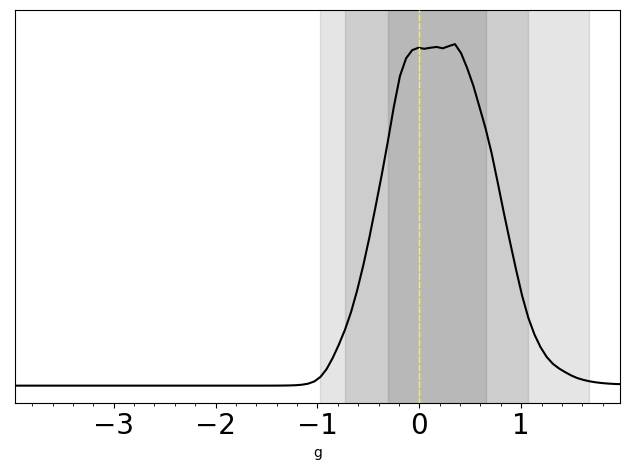

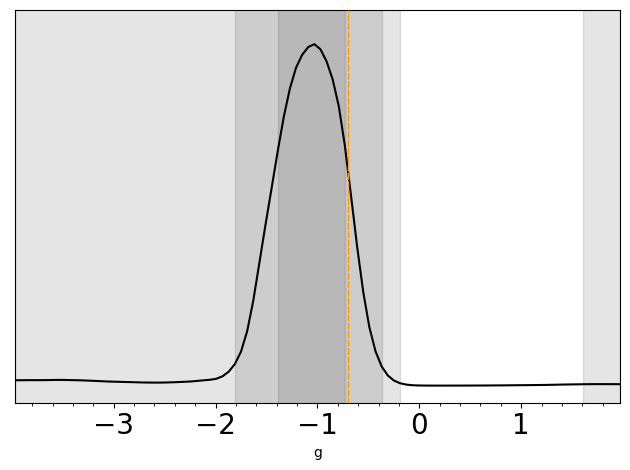

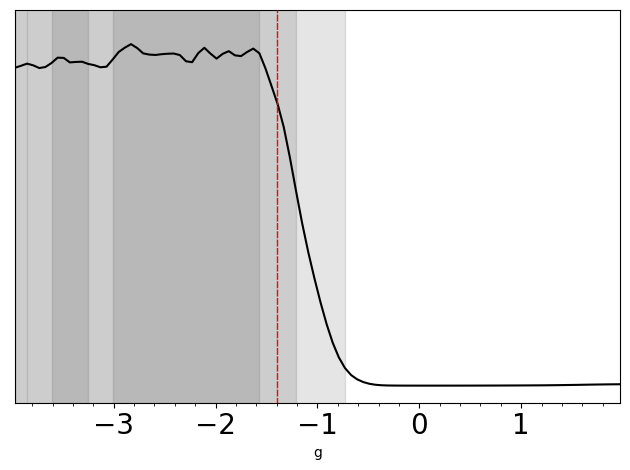

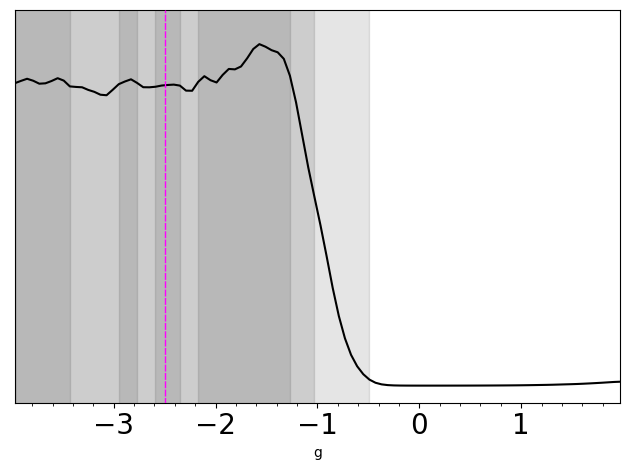

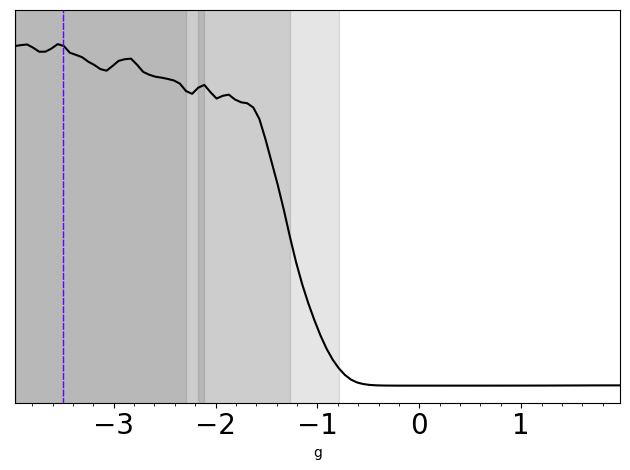

In [131]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            new_net,
                            observations[j],
                            prior_samples
                            )
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, A.param_names[0], truth={A.param_names[i]:truths[j][i] for i in range(1)}, color_truth=colors[j])